In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("module.jl")
using .PhasorNetworks

In [3]:
using Plots

In [4]:
using LinearAlgebra: triu, diagm, diag

In [5]:
using Statistics: std

In [6]:
using QuadGK

# Construct a random graph

In [7]:
function generate_er_graph(n::Int, p::Real, self_loops::Bool = false)
    adj = rand(Float64, (n, n)) .< p
    #make undirected
    adj = triu(adj)
    adj =  (adj .+ adj') .> 0

    if !self_loops
        #remove self-loops
        for i in 1:n
            adj[i,i] = 0
        end
    end

    return adj
end

generate_er_graph (generic function with 2 methods)

In [8]:
g1 = generate_er_graph(20, 0.1)

20×20 BitMatrix:
 0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  1
 0  1  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  1  0  1  0  0  0  1  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0  1  0  0  1
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  0  1  0
 0  0  0  0  0  0  0  0

# Embed it into an HD vector

In [9]:
function graph_to_vector(graph::AbstractMatrix, nd::Int)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    #create vectors representing the nodes
    node_values = random_symbols((n, nd))
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = zeros(Float64, n_edges, nd)

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = node_values[tx,:]
        rx_symbol = node_values[rx,:]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol)
        edge_values[i,:] = edge_symbol
    end

    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = bundle(edge_values, dims=1)
    return node_values, graph_embedding
end

graph_to_vector (generic function with 1 method)

In [ ]:
function graph_to_vector(graph::AbstractMatrix, nd::Int, spk_args::SpikingArgs, repeats::Int=3)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    #create vectors representing the nodes
    node_values = random_symbols((n, nd)), spk_args, repeats=repeats) 
    train_values = [phase_to_train(node, spk_args, repeats=repeats) for node in eachslice(node_values, dims=1)]
    tspan = (0.0, repeats * 1.0)
    
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = []

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = train_values[tx]
        rx_symbol = train_values[rx]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol, spk_args=spk_args, tspan=tspan)
        append!(edge_values, edge_symbol)
    end

    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = bundle(edge_values, dims=1)
    return node_values, graph_embedding
end

graph_to_vector (generic function with 1 method)

In [10]:
nv1, gv1 = graph_to_vector(g1, 1024)

([-0.2754732370376587 -0.5016903877258301 … 0.6005518436431885 0.22015047073364258; 0.9498612880706787 -0.5992722511291504 … -0.11188995838165283 -0.1328566074371338; … ; -0.7651337385177612 0.4626576900482178 … 0.28100717067718506 -0.0611649751663208; 0.9570685625076294 -0.9708253145217896 … -0.3959360122680664 -0.8934869766235352], [0.09885957033087771 0.27706372715511973 … -0.7706423643705347 -0.3586707570393197])

In [11]:
nv1 |> size

(20, 1024)

In [12]:
gv1

1×1024 Matrix{Float64}:
 0.0988596  0.277064  -0.339606  -0.340202  …  0.287961  -0.770642  -0.358671

# Use similarity to reconstruct the graph

In [13]:
function query_edges(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

In [14]:
rec1 = query_edges(gv1, nv1)

20×20 Matrix{Float64}:
 -0.0105014    -0.0202115    0.032302     …  -0.00571046  -0.00853091
 -0.0202115     0.00622622   0.155051         0.181363     0.173903
  0.032302      0.155051     0.00980884      -0.0137986   -0.00563397
 -0.0255302     0.0424159    0.024361         0.0132899    0.0124551
 -0.00658028    0.016332    -0.0313304       -0.00629958   0.0149279
  0.0229868     0.0299877   -0.00910967   …  -0.00592332  -0.0127
  0.0182968    -0.0146643   -0.0158786        0.014525     0.00659549
  0.15567       0.00140778  -0.0303301        0.0109511    0.00162398
  0.017347      0.0105108   -0.00588262       0.018774    -0.000700279
 -0.0215432     0.0417705    0.0126112        0.18499      0.0119766
 -0.00712416   -0.0117872    0.0104995    …  -0.0197463   -0.0152456
  0.0218663     0.180182     0.198415        -0.013211    -0.0180224
  0.196237     -0.0150064    0.0135548       -0.0165844    0.196415
  0.0275615    -0.0347284    0.201792        -0.0134584    0.0157076
 -0.000813

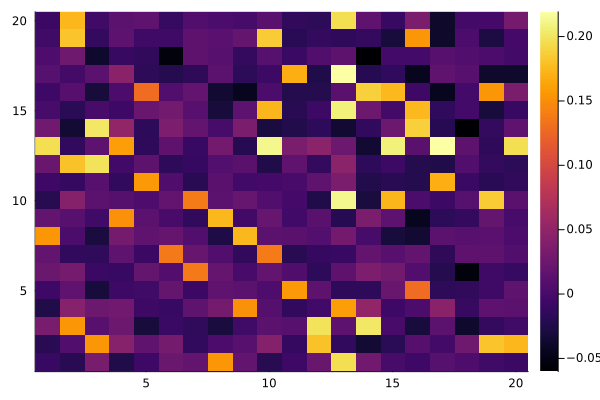

In [15]:
heatmap(rec1)

# Reconstruct the graph with oscillator operations

In [ ]:
function query_edges_osc(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

# Determine the quality of the reconstruction (AUROC)

In [16]:
tpr, fpr = tpr_fpr(vec(rec1), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

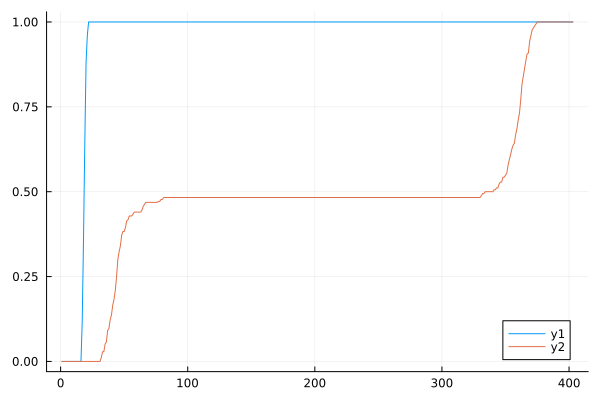

In [25]:
plot(tpr)
plot!(fpr)

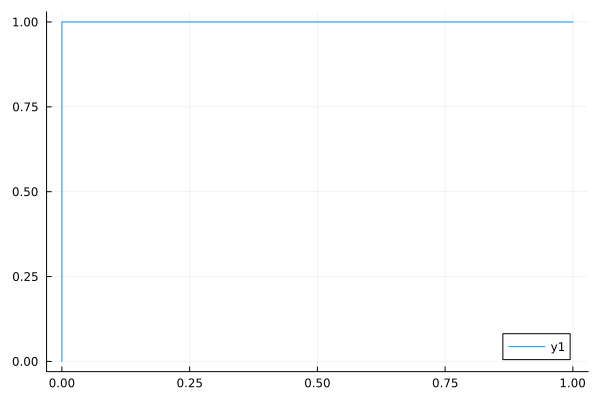

In [19]:
plot(fpr, tpr)

In [23]:
roc = interpolate_roc((tpr, fpr));

In [24]:
quadgk(x -> roc(x), 0.0, 1.0)

(1.0, 0.0)

# Run an experiment over multiple graphs